In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!pip install vncorenlp

     |████████████████████████████████| 2.6 MB 5.0 MB/s 
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645951 sha256=aaab95084452d3e11ad3c3a0fe3350d60d087c05f724e0f61979ef58e4a5451c
  Stored in directory: /root/.cache/pip/wheels/0c/d8/f2/d28d97379b4f6479bf51247c8dfd57fa00932fa7a74b6aab29
Successfully built vncorenlp


In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import re
from wordcloud import WordCloud 
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from scipy import sparse as sp

from sklearn.naive_bayes import GaussianNB,MultinomialNB, BernoulliNB
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [ ]:
path_data = "/content/gdrive/MyDrive/CS116 - Lập trình python cho máy học/data_train"

In [ ]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("/content/gdrive/MyDrive/CS117/vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 

###read data


In [ ]:
data = pd.read_csv("/content/gdrive/MyDrive/CS116 - Lập trình python cho máy học/data_train/data.csv")

In [ ]:
data = data[data.columns[1:]]
data

,Chinh tri Xa hoi,Phap luat,Kinh doanh,Doi song,Suc khoe,The gioi,The thao,Van hoa
0,Xử lý nghiêm các trường hợp xâm chiếm lòng hồ...,"Luật sư yêu cầu làm rõ 3,6 tỷ đồng hối lộ 'ngó...",Việt Nam đứng đầu ASEAN về tăng trưởng\r\nHội ...,Hải Anh đừng để phải nói hối tiếc như mình\r\n...,Ưa chảy máu - bệnh nguy hiểm chỉ có ở nam giới...,Hôm nay khai mạc hội nghị quốc tế về cúm gà\r\...,Chủ tịch VFF: “Chúng tôi sẽ xử lý cương quyết...,Kim Basinger - 50 tuổi vẫn muốn kết hôn\r\nDù ...
1,"TP.HCM: từ 5-11, kiểm tra toàn bộ hoạt động x...",Bắt giữ 370 chai rượu lậu\r\nPhòng cảnh sát ki...,Thổ Nhĩ Kỳ kiểm soát nhập khẩu dệt may VN\r\nT...,Hải Anh đừng lụy tình như thế\r\nSự thực là an...,Tìm ra nguyên nhân thoái hóa điểm vàng\r\nLần ...,'Iraq sẽ kiểm soát quân đội'\r\nTrong lá thư g...,"""Chúc mừng ý tưởng độc đáo của báo Tuổi Trẻ""\...",Quốc Bảo có chơi xấu đồng nghiệp?\r\nSau bài n...
2,Tranh luận tại quốc hội\r\nNăm 2003 khi làm d...,Phát hiện sai sót về tố tụng nhưng& vẫn y án \...,OPEC giữ nguyên sản lượng khai thác dầu\r\nKết...,"Điểm hấp dẫn phụ nữ \r\nĐể ghi điểm với nàng, ...",Lần đầu tiên mổ dị tật tim cho trẻ 4 tháng tuổ...,Gadhafi tiếc vì Reagan chết mà chưa hầu toà\r\...,"""Thế hệ vàng"" trở lại\r\nVăn Cường, người cắn...",Bóng đen phía sau vai diễn\r\nBiết được tâm lý...
3,Quốc hội thảo luận: 3 khuyết điểm của bộ máy ...,Đình chỉ chức vụ đối với ông Lương Quốc Dũng\r...,VN đứng thứ 56/70 nhóm các nước đang phát triể...,Gặp nhau mãi cũng chán\r\nMỗi tuần gặp nhau hế...,"Trang điểm chơi xuân\r\nTrong mùa này, bạn có ...",Đương kim tổng thống Philippines 'tái đắc cử'\...,“Áp lực nặng nề cho đội Anh”\r\nHLV Riedl cho...,Kim Ji Ho từ chối lời mời của Steven Spielberg...
4,Công bố “siêu nghị định” về đất đai\r\n- Thứ ...,Cán bộ điều tra Lê Thị Bích Ngọc phủ nhận việc...,VN nhập khẩu 30.000 tấn lúa mỳ từ Argentina\r\...,Hải Anh đã một lần thuyết phục mẹ anh ấy chưa?...,Cẩm nang cho cô dâu\r\nDo quá bận bịu nên nhiề...,Mỹ và Hàn Quốc đàm phán về cắt giảm binh sĩ\r\...,Phát hiện thêm một đường dây môi giới hối lộ ...,Nhà thơ Phan Vũ - người không đầu hàng tuổi tá...
...,...,...,...,...,...,...,...,...
1995,Nhà đất thuộc sở hữu Nhà nước: Không kê khai ...,Vụ ăn hối lộ ở Tân Thanh: Luật sư phản bác cáo...,Vốn đầu tư nước ngoài tăng mạnh\r\nTheo Bộ Kế ...,"Mẹ của tôi có người đàn ông khác\r\nGần đây, d...",Những câu hỏi thầm kín (1)\r\nBạn có thắc mắc ...,Thủ tướng Iraq bảo vệ sự hiện diện của lính Mỹ...,"Chương trình trận đấu chia tay ""Thế hệ vàng"":...",Won Bin đạt kỷ lục mới về lượng khán giả\r\nNg...
1996,"Hà Nội: tăng giá vé xe buýt \r\nTheo đó, giá ...",Điều tra vụ tranh giành khách giữa taxi Mai Li...,Tránh sai lầm trong quy hoạch tài chính\r\nDoa...,Hãy làm những gì Hải Anh cho là đúng\r\nNhững ...,Xoa bóp chữa sa dạ con \r\nSa dạ con là tình t...,Bạo lực tại một thành phố của Ảrập Xêút\r\nChi...,Xin cảm ơn tất cả!\r\nLà người từng hâm mộ và...,Kate Winslet - 2 con vẫn muốn chụp ảnh nude\r\...
1997,"Hạn hán gay gắt\r\nTheo báo cáo, mùa mưa ở Tâ...",Hé lộ đường dây vận chuyển ma túy lớn nhất nướ...,Các công ty Mỹ quay trở lại Libya\r\nTrong số ...,"Hạnh phúc luôn đi kèm với nỗi đau, Hải Anh à\r...",Văcxin - vị cứu tinh của con người\r\nVăcxin l...,"Anh, Mỹ công bố dự thảo nghị quyết Iraq mới\r\...",Trọng tài Nguyễn Hữu Thành đã nhận tiền từ ôn...,"Các diễn viên, nhóm hài được yêu thích nhất nă..."
1998,Tàu tết năm nay có gì mới?\r\n- Vừa qua ngành...,Vụ Minh 'Sứt': Chị gái Dung 'Hà' đổ tội cho em...,Cà phê tiếp tục tăng giá\r\n2005 sẽ là năm thứ...,Hải Anh đừng để vuột mất tình yêu này\r\nCác b...,Khi no say cấm 'nhập phòng'\r\nỞ Trung Quốc và...,Phụ tá của Zarqawi bị bắt ở Iraq \r\nGiới quân...,Cảm động phút hội ngộ\r\nTrưởng đoàn bóng đá ...,Quốc Bảo: 'Đỗ Bảo rơi tõm vào đám đông'\r\nVới...


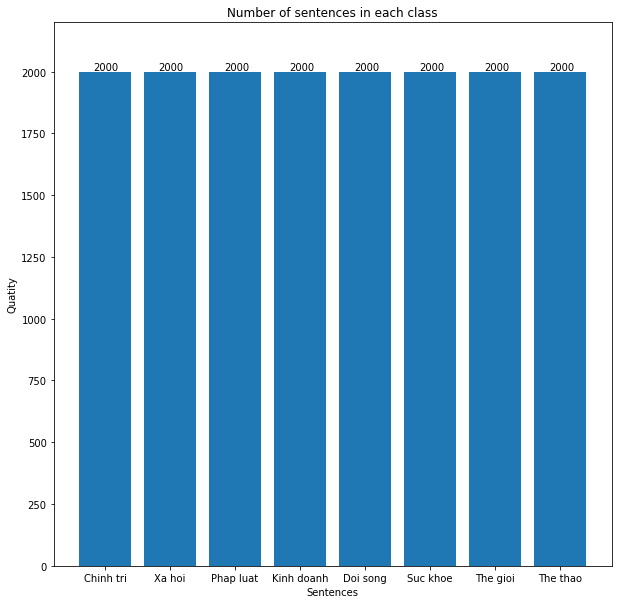

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
# Đếm số lượng nhãn theo từng loại
# Chuẩn bị dữ liệu:
# Sort Số lượng giảm dần
Counts = sorted([2000,2000,2000,2000,2000,2000,2000,2000], reverse=True)
labels = ["Chinh tri", "Xa hoi",	"Phap luat",	"Kinh doanh",	"Doi song",	"Suc khoe"	,"The gioi"	,"The thao",	"Van hoa"]
 
# Chỉ số các món ăn
ind_labels= range(8)
 
# Vẽ biểu đồ cột
plt.bar(ind_labels, Counts, align='center')
plt.xticks(ind_labels, labels)
 
# Label x, y axit
plt.xlabel('Sentences')
plt.ylabel("Quatity" )
# Label title of bar char
plt.title('Number of sentences in each class')
 
# Thêm các giá trị trên mỗi cột
for x, y in zip(ind_labels, Counts):
    plt.text(x+0.02, y+0.05, '%d' % y, ha='center', va= 'bottom')
 
# Tăng trục y thêm 20 đơn vị
plt.ylim(0, Counts[0] + 200)
 
# Cuối cùng là show kết quả!!!
plt.show()

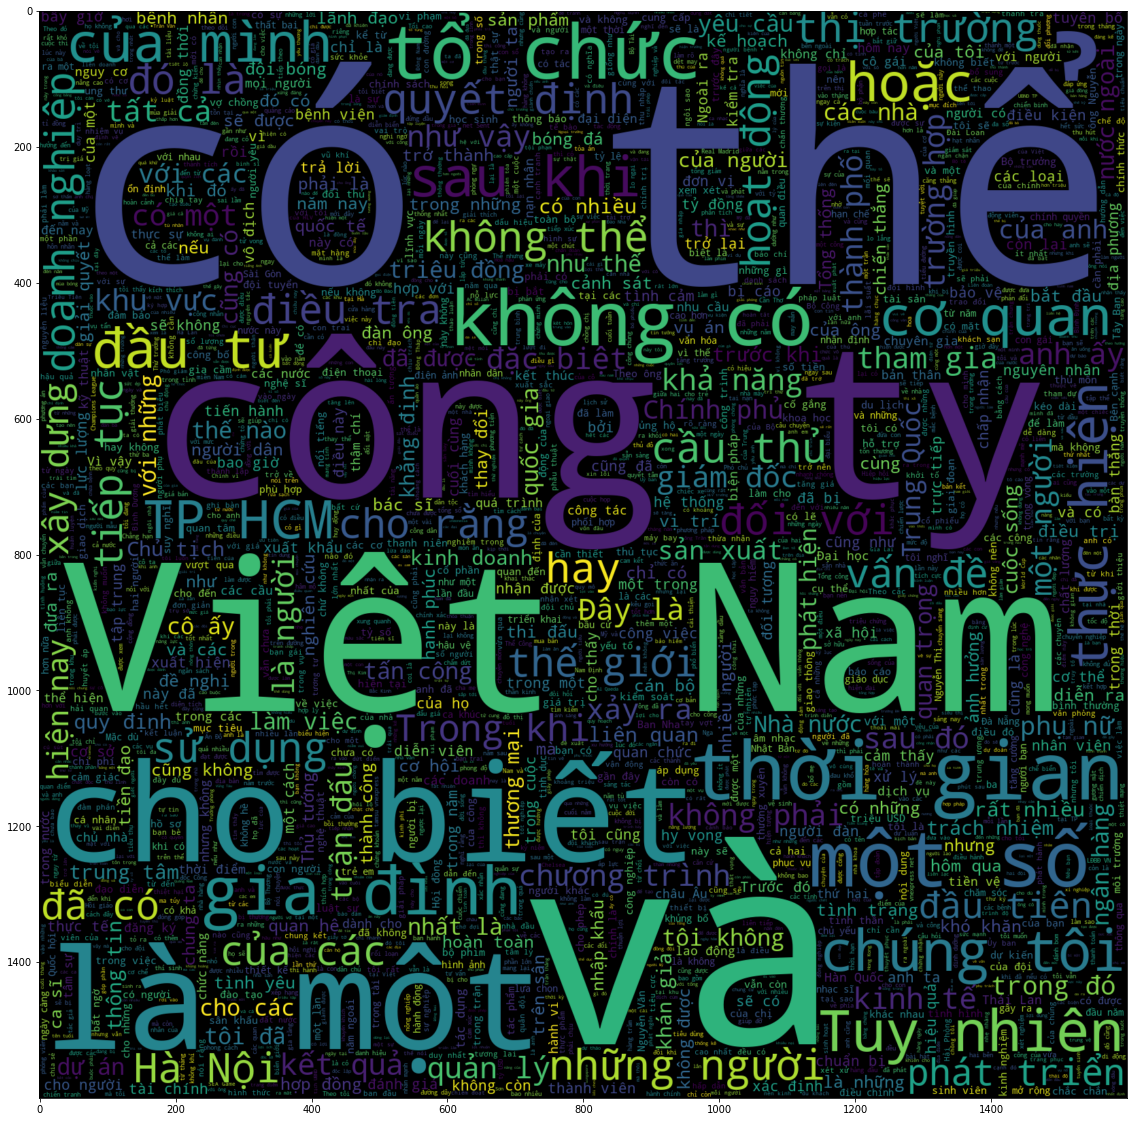

In [ ]:
plt.figure(figsize = (20,20)) 
text = ""
for i in data:
  for j in data[i]:
    text += j
wc = WordCloud(max_words = 2000 , width = 1600 , height = 1600).generate(text)
plt.imshow(wc , interpolation = 'bilinear')

In [ ]:
def preprocessing(text, lower_case = False, word_segment = True):
  #remove các ký tự kéo dài
  text = re.sub(r'([A-Za-zaăâbcdđeêghiklmnoôơpqrstuưvxyàằầbcdđèềghìklmnòồờpqrstùừvxỳáắấbcdđéếghíklmnóốớpqrstúứvxýảẳẩbcdđẻểghỉklmnỏổởpqrstủửvxỷạặậbcdđẹệghịklmnọộợpqrstụựvxỵãẵẫbcdđẽễghĩklmnõỗỡpqrstũữvxỹAĂÂBCDĐEÊGHIKLMNOÔƠPQRSTUƯVXYÀẰẦBCDĐÈỀGHÌKLMNÒỒỜPQRSTÙỪVXỲÁẮẤBCDĐÉẾGHÍKLMNÓỐỚPQRSTÚỨVXÝẠẶẬBCDĐẸỆGHỊKLMNỌỘỢPQRSTỤỰVXỴẢẲẨBCDĐẺỂGHỈKLMNỎỔỞPQRSTỦỬVXỶÃẴẪBCDĐẼỄGHĨKLMNÕỖỠPQRSTŨỮVXỸ])\1+', lambda m: m.group(1), text)
  #Remove sign
  sign = r"[!”#$%&’()*+,-./:;<=>?@[\]^_`{|}~\'\'""''``]"
  text =re.sub(sign, " ", text)
  # Chuyển thành chữ thường|
  if lower_case == True:
    text = text.lower()
  if word_segment == True:
    text = re.sub("\\s+", " ", text)
  text = " ".join(text.split())
  text = rdrsegmenter.tokenize(text)
  text = " ".join(text[0])
  return text


In [ ]:
def get_len(str):
  lst = preprocessing(str).split()
  return len(lst)
def get_max_min_len(data):
  max = 0
  min = 99999
  sum = 0
  for i in data:
    for j in data[i]:
      if get_len(j)>max:
        max = get_len(j)
        sentence_max = j
      if (get_len(j)<min):
        min = get_len(j)
        sentence_min = j
      sum += get_len(j)
  return max, min , sum/16000

In [ ]:
max_sent, min_sent, avg_sent = get_max_min_len(data)

In [ ]:
print("Độ dài câu dài nhất: "+ str(max_sent))
print("Độ dài câu ngắn nhất: " + str(min_sent))
print("Độ dài câu trung bình: "+ str(avg_sent))

Độ dài câu dài nhất: 8013
Độ dài câu ngắn nhất: 5
Độ dài câu trung bình: 353.03575


In [ ]:
def convert_label(count):
  label = np.zeros(8)
  label[count] = 1
  return label

In [ ]:
### tạo bộ train
Train = []
label = []
count = 0
list_category = data.columns
for i in list_category:
  for j in data[i]:
    text = preprocessing(j)
    Train.append(text)
    label.append(count)
  count +=1

In [ ]:
len(Train)
len(label)

16000

### Chia tập train và tập test

In [ ]:
#chia tập train tập test theo tỷ lệ 7/3
X_train, X_test, y_train, y_test = train_test_split(Train,label,test_size=0.3, shuffle=42)

In [ ]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

11200
11200
4800
4800


In [ ]:
print(X_train[1])

Hoàng_Vĩnh_Giang ông_già chiến_thắng Giám_đốc Sở TDT Hà_Nội Hoàng_Vĩnh_Giang vẫn được mọi người nhắc đến với cái tên như_vậy Ông là một trong những kiến_trúc_sư của công_trình 158 chiếc HC vàng mà đoàn thể_thao Việt_Nam đoạt được tại SEA_Games 22 Ngay cả những người không ưa ông cũng phải thừa_nhận đó là con_người của tầm_nhìn_xa Năm 1993 Nguyễn_Thuý_Hiền trở_thành nhà vô_địch thế_giới wushu đầu_tiên của thể_thao Việt_Nam Trong vai_trò phiên_dịch_viên cho nữ HLV người Trung_Quốc Trần_Húc_Hồng ông Hoàng_Vĩnh_Giang bảo " Đây mới chỉ là khúc nhạc dạo_đầu và không_chỉ wushu mà_còn cho nhiều môn thể_thao khác " Và lời_nói ngày nào của ông đã không sai SEA_Games 18 ông Giang đem quân nhảy_cầu đến Chiangmai_Những người Việt_Nam chứng_kiến quân ta thi_đấu hôm đó chắc ai cũng phải ngượng chín mặt VĐV nhảy_cầu của ta trông như những đứa bé quê thường tìm cái sướng bằng những cú nhảy đùng_đùng với nước bắn tung_toé thậm_chí lên tận cả khán_đài Sau cú nhảy của quân ông Giang nhiều trọng_tài không 

In [ ]:
print(y_train[1])

6


### Trích xuất đặc trưng


#### Phương pháp Bag-of-Words
- Khi sử dụng phương pháp này, chúng ta sẽ thu được một ma trận mà trong đó, mỗi hàng sẽ đại diện cho một văn bản, mỗi cột đại diện cho một từ có trong từ điển, và mỗi ô (cell) sẽ chứa tần suất xuất hiện của từ trong văn bản tương ứng. Bằng cách sử dụng thư viện sklearn, chúng ta sẽ làm như sau:

In [ ]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(X_train)

# transform the training and validation data using count vectorizer object
X_train_count = count_vect.transform(X_train)
X_test_count = count_vect.transform(X_test)


#### Phương pháp TF-IDF
- Phương pháp TF-IDF (Term Frequency - Inverse Document Frequency), đây là một phương pháp cực kì phổ biến trong xử lý văn bản. Nó được tính theo công thức dưới đây:

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)
IDF(t) = log_e(Total number of documents / Number of documents with term t in it)
Chúng ta có thể thực hiện TF-IDF cho các cấp độ khác nhau của văn bản như sau: a. Word Level TF-IDF : Thực hiện tính toán dựa trên mỗi thành phần là một từ riêng lẻ.

In [ ]:
tfidf_vect = TfidfVectorizer(analyzer='word', max_features=30000)
tfidf_vect.fit(X_train) # learn vocabulary and idf from training set
X_train_tfidf =  tfidf_vect.transform(X_train)
X_test_tfidf =  tfidf_vect.transform(X_test)

### do số chiều của vector đặc trưng quá lớn nên sẽ sử dụng kỹ thuật Singular Value Decomposition (SVD) để giảm số chiều xuống 300

In [ ]:
svd = TruncatedSVD(n_components=300, random_state=42)
svd.fit(X_train_count)

X_train_count_svd = svd.transform(X_train_count)
X_test_count_svd = svd.transform(X_test_count)

In [ ]:
svd = TruncatedSVD(n_components=300, random_state=42)
svd.fit(X_train_tfidf)

X_train_tfidf_svd = svd.transform(X_train_tfidf)
X_test_tfidf_svd = svd.transform(X_test_tfidf)

### Train model và predict

### Gaussian Naive Bayes¶

In [ ]:
nb_classifier = GaussianNB()
## sử dụng gridsearch để tìm tham số var_smoothing
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
gs_NB = GridSearchCV(estimator=nb_classifier, 
                 param_grid=params_NB, 
                 verbose=1, 
                 scoring='accuracy') 
## sử dụng đặc trưng của phương pháp bag of word sau khi svd
gs_NB.fit(X_train_count_svd, y_train).predict(X_test_count_svd)
gs_NB.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'var_smoothing': 8.111308307896873e-06}

In [ ]:
y_pred = gs_NB.predict(X_test_count_svd)
acc = accuracy_score(y_pred, y_test)
print("accuracy: " + str(acc))

accuracy: 0.37833333333333335


In [ ]:
nb_classifier = GaussianNB()
## sử dụng gridsearch để tìm tham số var_smoothing
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
gs_NB = GridSearchCV(estimator=nb_classifier, 
                 param_grid=params_NB, 
                 verbose=1, 
                 scoring='accuracy') 
## sử dụng đặc trưng của phương pháp tf-idf sau khi svd
gs_NB.fit(X_train_tfidf_svd, y_train).predict(X_test_tfidf_svd)
gs_NB.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'var_smoothing': 0.0003511191734215131}

In [ ]:
y_pred = gs_NB.predict(X_test_tfidf_svd)
acc = accuracy_score(y_pred, y_test)
print("accuracy: " + str(acc))

accuracy: 0.7614583333333333


###  Multinomial Naive Bayes¶
- Sử dụng kỹ thuật SVD để giảm chiều dữ liệu nên trong vector đặc trưng có giá trị ấm nên không thể sử dụng mô hình này để train. 
- Có thể sử dụng mô hình này nếu không sử dụng kỹ thuật svd nhưng do chiều dữ liệu lớn đòi hỏi cấu hình phần cứng cao nên nhóm không thể thực hiện mô hình này 
 - Negative values in data passed to MultinomialNB (input X)

In [ ]:
print(X_train_count_svd)

[[ 6.80605172  2.52022887  0.99704143 ...  0.25403225 -0.66015241
  -0.06578593]
 [27.53294275  6.8951738  -1.72712149 ...  1.17194914  0.35652855
   1.07859519]
 [ 3.24507579  1.88814051  0.56467734 ...  0.10018574 -0.09365711
   0.25343235]
 ...
 [45.4474735  12.82304409  3.07519597 ... -2.86560082 -0.92116542
  -2.69279298]
 [ 4.81480526  2.86553428  2.26997733 ... -0.17104985  0.57387526
  -0.29042035]
 [22.66696432 -3.08225717  1.3335932  ...  0.29782434  0.60572513
   1.48819036]]


In [ ]:
## sử dụng đặc trưng của phương pháp bag of words
# mul = MultinomialNB(alpha=0.001)
# y_pred = mul.fit(X_train_tfidf_svd, y_train).predict(X_test_tfidf_svd)
# acc = accuracy_score(y_pred, y_test)
# print("accuracy: " + str(acc))

### Bernoulli Naive Bayes

In [ ]:
ber = BernoulliNB()
## sử dụng grid search để tìm kiếm các siêu tham số binarize, alpha và fit_prior
params_ber = {'binarize': [0,0.1, 0.2, 0.3,0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'alpha' : [1,2,3], 'fit_prior': [True, False] }
gs_ber = GridSearchCV(estimator=ber, 
                 param_grid=params_ber, 
                 verbose=1, 
                 scoring='accuracy') 
## sử dụng đặc trưng của phương pháp bag of words sau khi svd
gs_ber.fit(X_train_count_svd, y_train)
gs_ber.best_params_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


{'alpha': 1, 'binarize': 0, 'fit_prior': True}

In [ ]:
y_pred = gs_ber.predict(X_test_count_svd)
acc = accuracy_score(y_pred, y_test)
print("accuracy: " + str(acc))

accuracy: 0.804375


In [ ]:
ber = BernoulliNB()
## sử dụng grid search để tìm kiếm các siêu tham số binarize, alpha và fit_prior
params_ber = {'binarize': [0,0.1, 0.2, 0.3,0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'alpha' : [1,2,3], 'fit_prior': [True, False] }
gs_ber = GridSearchCV(estimator=ber, 
                 param_grid=params_ber, 
                 verbose=1, 
                 scoring='accuracy') 
### sử dụng đặc trưng của phương pháp tf-idf sau khi svd
gs_ber.fit(X_train_tfidf_svd, y_train)
gs_ber.best_params_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


{'alpha': 1, 'binarize': 0, 'fit_prior': True}

In [ ]:
y_pred = gs_ber.predict(X_test_tfidf_svd)
acc = accuracy_score(y_pred, y_test)
print("accuracy: " + str(acc))

accuracy: 0.843125


### Thử nghiệm chạy một số mô hình khác

#### SVM

In [ ]:
from sklearn import svm
## sử dụng grid search để tìm các tham số
param_grid = {'C': [0.1, 1, 10],
              'gamma': [1, 0.1, 0.01]}
# sử dụng đặc trưng bows sau khi svd
clf = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3).fit(X_train_count_svd, y_train)
clf.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ....................C=0.1, gamma=1;, score=0.126 total time=  38.2s
[CV 2/5] END ....................C=0.1, gamma=1;, score=0.127 total time=  38.7s
[CV 3/5] END ....................C=0.1, gamma=1;, score=0.127 total time=  39.9s
[CV 4/5] END ....................C=0.1, gamma=1;, score=0.127 total time=  38.1s
[CV 5/5] END ....................C=0.1, gamma=1;, score=0.127 total time=  39.3s
[CV 1/5] END ..................C=0.1, gamma=0.1;, score=0.126 total time=  37.7s
[CV 2/5] END ..................C=0.1, gamma=0.1;, score=0.127 total time=  36.6s
[CV 3/5] END ..................C=0.1, gamma=0.1;, score=0.127 total time=  36.4s
[CV 4/5] END ..................C=0.1, gamma=0.1;, score=0.127 total time=  35.9s
[CV 5/5] END ..................C=0.1, gamma=0.1;, score=0.127 total time=  35.8s
[CV 1/5] END .................C=0.1, gamma=0.01;, score=0.387 total time=  34.2s
[CV 2/5] END .................C=0.1, gamma=0.01;,

{'C': 10, 'gamma': 0.01}

In [ ]:
pred = clf.predict(X_test_count_svd)
acc = accuracy_score(y_pred, y_test)
print("accuracy: " + str(acc))

accuracy: 0.804375


In [ ]:
param_grid = {'C': [0.1, 1, 10],
              'gamma': [1, 0.1, 0.01]}
# sử dụng đặc trưng bows sau khi svd
clf = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3).fit(X_train_tfidf_svd, y_train)
clf.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ....................C=0.1, gamma=1;, score=0.904 total time=  17.3s
[CV 2/5] END ....................C=0.1, gamma=1;, score=0.918 total time=  19.6s
[CV 3/5] END ....................C=0.1, gamma=1;, score=0.911 total time=  18.8s
[CV 4/5] END ....................C=0.1, gamma=1;, score=0.906 total time=  21.3s
[CV 5/5] END ....................C=0.1, gamma=1;, score=0.904 total time=  22.2s
[CV 1/5] END ..................C=0.1, gamma=0.1;, score=0.732 total time=  38.7s
[CV 2/5] END ..................C=0.1, gamma=0.1;, score=0.749 total time=  36.8s
[CV 3/5] END ..................C=0.1, gamma=0.1;, score=0.748 total time=  38.1s
[CV 4/5] END ..................C=0.1, gamma=0.1;, score=0.733 total time=  44.5s
[CV 5/5] END ..................C=0.1, gamma=0.1;, score=0.751 total time=  34.7s
[CV 1/5] END .................C=0.1, gamma=0.01;, score=0.126 total time=  39.4s
[CV 2/5] END .................C=0.1, gamma=0.01;,

{'C': 1, 'gamma': 1}

In [ ]:
y_pred = clf.predict(X_test_tfidf_svd)
acc = accuracy_score(y_pred, y_test)
print("accuracy: " + str(acc))

accuracy: 0.9379166666666666


### Decision Trees

In [ ]:
from sklearn import tree
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [None,3,5,7,9,11]}
# sử dụng đặc trưng bog sau khi svd
tree1 = tree.DecisionTreeClassifier()
tree_finetune = GridSearchCV(tree1, param_grid, refit = True, verbose = 3).fit(X_train_count_svd, y_train)
tree_finetune.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ....criterion=gini, max_depth=None;, score=0.600 total time=   4.4s
[CV 2/5] END ....criterion=gini, max_depth=None;, score=0.608 total time=   4.4s
[CV 3/5] END ....criterion=gini, max_depth=None;, score=0.595 total time=   4.5s
[CV 4/5] END ....criterion=gini, max_depth=None;, score=0.604 total time=   4.3s
[CV 5/5] END ....criterion=gini, max_depth=None;, score=0.626 total time=   4.3s
[CV 1/5] END .......criterion=gini, max_depth=3;, score=0.459 total time=   1.2s
[CV 2/5] END .......criterion=gini, max_depth=3;, score=0.492 total time=   1.2s
[CV 3/5] END .......criterion=gini, max_depth=3;, score=0.456 total time=   1.2s
[CV 4/5] END .......criterion=gini, max_depth=3;, score=0.492 total time=   1.2s
[CV 5/5] END .......criterion=gini, max_depth=3;, score=0.485 total time=   1.2s
[CV 1/5] END .......criterion=gini, max_depth=5;, score=0.580 total time=   1.9s
[CV 2/5] END .......criterion=gini, max_depth=5;

{'criterion': 'entropy', 'max_depth': 9}

In [ ]:
y_pred = tree_finetune.predict(X_test_count_svd)
acc = accuracy_score(y_pred, y_test)
print("accuracy: " + str(acc))

accuracy: 0.649375


In [ ]:
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [None,3,5,7,9,11]}
# sử dụng đặc trưng bows sau khi svd
from sklearn import tree
tree2 = tree.DecisionTreeClassifier()
tree_finetune = GridSearchCV(tree2, param_grid, refit = True, verbose = 3).fit(X_train_tfidf_svd, y_train)
tree_finetune.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ....criterion=gini, max_depth=None;, score=0.808 total time=   6.4s
[CV 2/5] END ....criterion=gini, max_depth=None;, score=0.813 total time=   6.5s
[CV 3/5] END ....criterion=gini, max_depth=None;, score=0.790 total time=   6.0s
[CV 4/5] END ....criterion=gini, max_depth=None;, score=0.812 total time=   5.6s
[CV 5/5] END ....criterion=gini, max_depth=None;, score=0.798 total time=   6.3s
[CV 1/5] END .......criterion=gini, max_depth=3;, score=0.526 total time=   1.2s
[CV 2/5] END .......criterion=gini, max_depth=3;, score=0.512 total time=   1.3s
[CV 3/5] END .......criterion=gini, max_depth=3;, score=0.524 total time=   1.3s
[CV 4/5] END .......criterion=gini, max_depth=3;, score=0.518 total time=   1.2s
[CV 5/5] END .......criterion=gini, max_depth=3;, score=0.527 total time=   1.3s
[CV 1/5] END .......criterion=gini, max_depth=5;, score=0.777 total time=   2.0s
[CV 2/5] END .......criterion=gini, max_depth=5;

{'criterion': 'gini', 'max_depth': 11}

In [ ]:
y_pred = tree_finetune.predict(X_test_tfidf_svd)
acc = accuracy_score(y_pred, y_test)
print("accuracy: " + str(acc))

accuracy: 0.8375


## So sánh kết quả giữa các phương pháp

In [ ]:
result = [0.378,0.761,0.804, 0.843, 0.804, 0.938, 0.649, 0.838]
name = ["BoW_Gaussian",  "TF-IDF_Gaussian","BoW_Bernoulli", "TF-IDF_Bernoulli", "BoW_SVM", "TF-IDF_SVM", "BoW_DecisionTree", "TF-IDF_DecisionTree"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


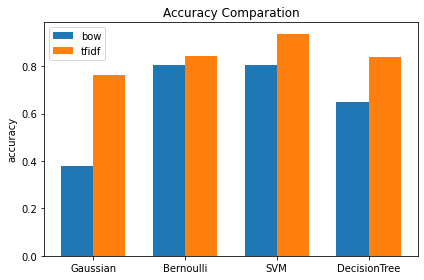

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


labels =  ["Gaussian",  "Bernoulli" , "SVM", "DecisionTree"]
bow_mean = [0.378,0.804, 0.804,0.649]
tfidf_mean = [0.761, 0.843, 0.938, 0.838]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, bow_mean, width, label='bow')
rects2 = ax.bar(x + width/2, tfidf_mean, width, label='tfidf')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('accuracy')
ax.set_title('Accuracy Comparation')
ax.set_xticks(x, labels)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

## nhận xét:
- Mô hình Naive Bayes có siêu tham số ít dễ ước lượng và dễ dàng sử dụng thuật toán gridsearch để tìm kiếm tham số
- Đối với thời gian chạy: Mô hình Bernouli Naive Bayes và Gaussian Naive Bayes cho thời gian chạy nhanh và thời gian sử dụng gridsearch để tìm kiếm siêu tham số nhanh hơn so với thuật toán SVM và Decision Tree
- Độ chính xác: Kết quả tương đối tốt so với các mô hình thử nghiệm. Trong đó mô hình Bernouli khi sử dụng đặc trưng của phương pháp trích xuất đặc trưng TF-IDF cho kết quả tốt thứ 2 chỉ sau mô hình SVM khi sử dụng đặc của của TF-IDF.
- Trong 2 phương pháp trích xuất đặc trưng từ dữ liệu văn bản thì phương pháp trích xuất đặc trưng TF-IDF đều cho kết quả tốt hơn phương pháp Bag of Words